In [1]:
import jax
import jax.numpy as jnp

# gradients

In [52]:
def f(x):
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2)
    return ln_x/ln_2

from jax import make_jaxpr

x_0 = 2.0

make_jaxpr(f)(x_0)  # let's watch JAX trace the function! 

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }

In [53]:
gradient = jax.grad(f)
make_jaxpr(gradient)(x_0)  # this is the JAX expression for the gradient
# note how the original expression is embedded in the gradient expression!
# this is JAX tracing the computation graph and then using the primitive rules
# for log and division to compute the gradient (d/dx log(x) = 1/x, d/dx x/y = 1/y)

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    _:f32[] = div b c
    d:f32[] = div 1.0 c
    e:f32[] = div d a
  in (e,) }

Here's the step-by-step representation of the given expression using LaTeX equations:

Step 1:
$ b = \log(a) $

Step 2:
$ c = \log(2.0) $

Step 3:
$ \_ = \frac{b}{c} $

Step 4:
$ d = \frac{1.0}{c} = \frac{1.0}{\log(2.0)} $, which is $\frac{\partial \_}{\partial b}$

Step 5:
$ e = \frac{d}{a} $, which is $\frac{\partial \_}{\partial b} \cdot \frac{\partial b}{\partial a}$ ,

since $\frac{\partial b}{\partial a} = \frac{\partial \log(a)}{\partial a} = \frac{1}{a}$

Step 6:
 return $e $


In [54]:
gradient(x_0)

Array(0.7213475, dtype=float32, weak_type=True)

In [55]:
1 / (x_0 * jnp.log(2))

Array(0.7213475, dtype=float32, weak_type=True)

In [56]:
# here's the gradient of the gradient
make_jaxpr(jax.grad(gradient))(x_0)

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    _:f32[] = div b c
    d:f32[] = div 1.0 c
    _:f32[] = div d a
    e:f32[] = integer_pow[y=-2] a
    f:f32[] = mul 1.0 e
    g:f32[] = mul f d
    h:f32[] = neg g
  in (h,) }

In [57]:
# which is the derivative of 1/x = -1/x^2
-1 / (x_0**2 * jnp.log(2)) == jax.grad(gradient)(x_0)

Array(True, dtype=bool, weak_type=True)

In [58]:
# we could go forever:
make_jaxpr(jax.grad(jax.grad(jax.grad(jax.grad(jax.grad(jax.grad(jax.grad(jax.grad(f)))))))))(x_0)

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    _:f32[] = div b c
    d:f32[] = div 1.0 c
    _:f32[] = div d a
    _:f32[] = integer_pow[y=-2] a
    _:f32[] = integer_pow[y=-2] a
    e:f32[] = integer_pow[y=-3] a
    _:f32[] = mul -2.0 e
    _:f32[] = integer_pow[y=-2] a
    f:f32[] = integer_pow[y=-3] a
    _:f32[] = mul -2.0 f
    g:f32[] = integer_pow[y=-3] a
    h:f32[] = integer_pow[y=-4] a
    _:f32[] = mul -3.0 h
    _:f32[] = mul -2.0 g
    _:f32[] = integer_pow[y=-2] a
    i:f32[] = integer_pow[y=-3] a
    _:f32[] = mul -2.0 i
    j:f32[] = integer_pow[y=-3] a
    k:f32[] = integer_pow[y=-4] a
    _:f32[] = mul -3.0 k
    _:f32[] = mul -2.0 j
    l:f32[] = integer_pow[y=-3] a
    m:f32[] = integer_pow[y=-4] a
    _:f32[] = mul -3.0 m
    n:f32[] = integer_pow[y=-4] a
    o:f32[] = integer_pow[y=-5] a
    _:f32[] = mul -4.0 o
    _:f32[] = mul -3.0 n
    _:f32[] = mul -2.0 l
    _:f32[] = integer_pow[y=-2] a
    p:f32[] = integer_pow[y=-3] a
    _:f32[] =

In [27]:
# here's another function: a layer of a neural network
def mlp(x, w, b):
    return jnp.dot(w, x) + b

x = 9.0
w = 3.0
b = 1.0

make_jaxpr(mlp)(x, w, b)

{ lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul b a
    e:f32[] = add d c
  in (e,) }

In [28]:
# the gradient of f with respect to w
make_jaxpr(jax.grad(mlp, argnums=1))(x, w, b)

{ lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul b a
    _:f32[] = add d c
    e:f32[] = mul 1.0 a
  in (e,) }

In [32]:
# analytical gradient is just x
x == jax.grad(mlp, argnums=1)(x, w, b)

Array(True, dtype=bool, weak_type=True)

In [80]:
# now let's get crazy: here's the attention mechanism from the Transformer
# (https://arxiv.org/abs/1706.03762)

def softmax(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x))

def scaled_dot_product_attention(q, k, v):
    qk = jnp.dot(q, k.T) / jnp.sqrt(q.shape[-1])
    weights = softmax(qk)
    return jnp.dot(weights, v)

def attention(weights, e):
    Wq = weights["Wq"]
    Wk = weights["Wk"]
    Wv = weights["Wv"]

    q = jnp.dot(Wq, e)
    k = jnp.dot(Wk, e)
    v = jnp.dot(Wv, e)
    return scaled_dot_product_attention(q, k, v)

Wq = jnp.array([[1.0, 0.1, 0.0],
                [0.0, 1.0, 0.1],
                [0.1, 0.0, 1.0]])

Wk = jnp.array([[1.0, 0.0, 0.1],
                [0.1, 1.0, 0.0],
                [0.0, 0.1, 1.0]])

Wv = jnp.array([[1.0, 0.1, 0.0],
                [0.0, 1.0, 0.1],
                [0.1, 0.0, 1.0]])


e = jnp.array([1.0, 2.0, 3.0])

make_jaxpr(attention)(dict(Wq=Wq, Wk=Wk, Wv=Wv), e)

{ lambda ; a:f32[3,3] b:f32[3,3] c:f32[3,3] d:f32[3]. let
    e:f32[3] = dot_general[dimension_numbers=(([1], [0]), ([], []))] b d
    f:f32[3] = dot_general[dimension_numbers=(([1], [0]), ([], []))] a d
    g:f32[3] = dot_general[dimension_numbers=(([1], [0]), ([], []))] c d
    h:f32[] = dot_general[dimension_numbers=(([0], [0]), ([], []))] e f
    i:f32[] = sqrt 3.0
    j:f32[] = convert_element_type[new_dtype=float32 weak_type=False] i
    k:f32[] = div h j
    l:f32[] = exp k
    m:f32[] = exp k
    n:f32[] = reduce_sum[axes=()] m
    o:f32[] = div l n
    p:f32[3] = mul o g
  in (p,) }

In [82]:
attention(dict(Wq=Wq, Wk=Wk, Wv=Wv), e)

Array([1.2, 2.3, 3.1], dtype=float32)

In [81]:
# the gradient of the attention mechanism with respect to the weights
# note that we have to use the full jacobian, since the output of our function
# is a vector, not a scalar
# the result is a 3x3 matrix, where each row is the gradient of the output
# with respect to the corresponding row of the weight matrix
# note how simple the Wv gradient is, since all we do is a dot product
jax.jacobian(attention, argnums=0)(dict(Wq=Wq, Wk=Wk, Wv=Wv), e)

{'Wk': Array([[[-8.2590617e-08, -1.6518123e-07, -2.4777185e-07],
         [-1.5829868e-07, -3.1659735e-07, -4.7489601e-07],
         [-2.1335909e-07, -4.2671817e-07, -6.4007725e-07]],
 
        [[-1.6518123e-07, -3.3036247e-07, -4.9554370e-07],
         [-3.1659735e-07, -6.3319470e-07, -9.4979202e-07],
         [-4.2671817e-07, -8.5343635e-07, -1.2801545e-06]],
 
        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32),
 'Wq': Array([[[-8.9473168e-08, -1.7894634e-07, -2.6841951e-07],
         [-1.4453357e-07, -2.8906715e-07, -4.3360072e-07],
         [-2.2024165e-07, -4.4048329e-07, -6.6072494e-07]],
 
        [[-1.7894634e-07, -3.5789267e-07, -5.3683902e-07],
         [-2.8906715e-07, -5.7813429e-07, -8.6720144e-07],
         [-4.4048329e-07, -8.8096658e-07, -1.3214499e-06]],
 
        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0

# vmap (automatic vectorization)

have you ever written a very simple function that you wanted to apply to a large array of inputs? numpy makes this easy with vectorization, but jax takes it a step further with vmap.

vmap is a function transformation that allows you to take a function that operates on a single input, and transform it into a function that operates on many inputs in a vectorized manner.


First example: zipping!

in python, zip is a function that takes two lists and returns a list of pairs, operated on in-step:

```python
out = [f(x[i],y[i]) for zip(x,y)]
```

here's how you would do it in jax:

In [103]:
def func(x,y):
    return x+y

x_batched = jnp.array([1,2,3])
y_batched = jnp.array([4,5,6])
vmap_func = jax.vmap(func, in_axes = (0,0))
vmap_func(x_batched,y_batched)  # [x1+y1, x2+y2, x3+y3]

Array([5, 7, 9], dtype=int32)

what about vectorising over non-leading axes?


t can happen that your batch dimension for the various arguments differ

for example, we may want to perform the same sum above, but our axes are at different positions for the two arguments

```python3
x = [[1,2,3]] # shape (1,3)
y = [[4],[5],[6] # shape (3,1)
```
In this case our Python code would look like

```python3
out = [f(x[0][i],x[i][0]) for i, (x,y) in enumerate(zip(x,y))]
```
JAX can handle this no problem!


In [107]:
x_batched = jnp.array([[1,2,3]])
y_batched = jnp.array([[4],[5],[6]])
# here, we specify that the first argument is batched along axis 1, 
# and the second argument is batched along axis 0.
# we also specify where we want the batched axis to be in the output
out1 = jax.vmap(func, in_axes = (1,0), out_axes=1)(x_batched,y_batched)
out1

Array([[5, 7, 9]], dtype=int32)


for example, consider the following function that would be a litte tricky to vectorize with numpy:


In [59]:
def predict(params, inputs):
  for W, b in params:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.tanh(outputs)
  return outputs

params = [
    (jnp.array([[1., 2.], [3., 4.]]), jnp.array([1., 1.])),
]  # params is a list of (weights, biases) arrays

inputs = jnp.array([[1., 2.]])
predict(params, inputs)


we can use vmap to vectorize this function over multiple inputs:



In [64]:
batched_predict = jax.vmap(predict, in_axes=(None, 0))

many_inputs = jnp.array([[1., 2.], [3., 4.], [5., 6.]])
batched_predict(params, many_inputs)  # shape: (batch_size, output_size)

Array([[ 8., 11.],
       [16., 23.],
       [24., 35.]], dtype=float32)

with a maximum of three brain cells, we have implemented batching! :)

the `in_axes` argument specifies which of the function’s arguments to batch over. in this case, we want to batch over the second argument, which is the inputs. the first argument, params, will be left unchanged -- it will be as if we called predict in a for loop over each of the inputs.


In [83]:
# just like grad, vmap can be composed
batch_of_batches = jnp.array([many_inputs, many_inputs])
batched_batched_predict = jax.vmap(batched_predict, in_axes=(None, 0))
batched_batched_predict(params, batch_of_batches) # shape: (batch, batch, output)

Array([[[ 8., 11.],
        [16., 23.],
        [24., 35.]],

       [[ 8., 11.],
        [16., 23.],
        [24., 35.]]], dtype=float32)

here's another one of my favorite examples -- operating over pairs of inputs using nested vmaps:

In [95]:
x_range = jnp.linspace(-5,5)
y_range = jnp.linspace(-2,2)


def func(x,y):
    return jnp.sin(x)*y

import numpy as np

# this is the unbroadcasted version
out_np = np.zeros((len(x_range),len(y_range)))
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):
        out_np[i,j] = func(x,y)


# maybe not the best example since it's actually completely vectorizable already
x_grid, y_grid = np.meshgrid(x_range,y_range, indexing = 'ij')
out_np = func(x_grid.T,y_grid.T)


# but, if you only had the implementation for a single x and y, you could use vmap
# start with the inner function, which batches over x and leaves y constant
inner_func = jax.vmap(func, in_axes = (0,None))
# then leave x constant, and batch over y
outer_func = jax.vmap(inner_func, in_axes = (None,0))
# the result is a function that works over the entire grid
out = outer_func(x_range,y_range)

# I like this because it lets me control the level of batching :)
# we could do this for unlimited dimensions - just keep adding vmaps
# for me thats great cause my head hurts when i try to do stuff with 6-D tensors in numpy...

out_np.shape, out.shape

((50, 50), (50, 50))

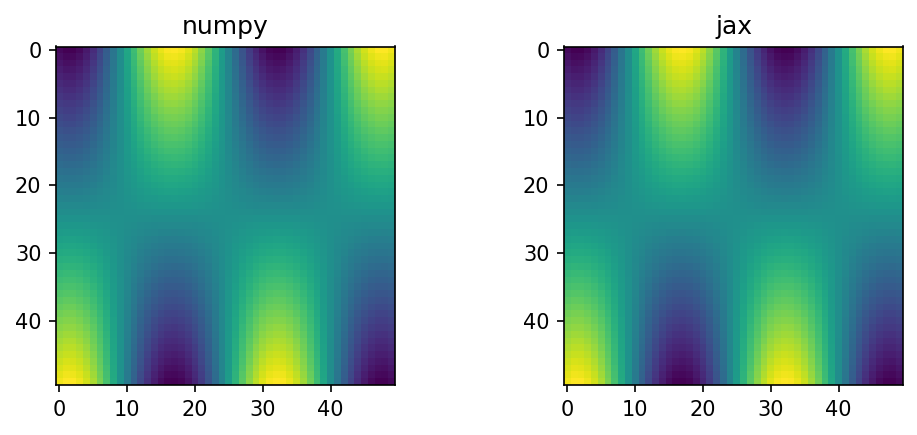

In [101]:
import matplotlib.pyplot as plt
subplot_settings = dict(figsize=[7, 3], dpi=150, tight_layout=True)
fig, axs = plt.subplots(1, 2, **subplot_settings)
axs[0].imshow(out_np)
axs[0].set_title("numpy")
axs[1].imshow(out)
axs[1].set_title("jax")
plt.show()

# jit (aka free speed)

jit is a function transformation that will take a function and return a "compiled" version of it that will be optimized for the hardware you run it on. in almost all cases, using jit will dramatically improve the performance of your functions.


In [114]:
# here's a complicated function that we want to speed up
def complicated_function(x):
    for _ in range(100):
        x = np.sin(x)
    for _ in range(100):
        x = np.cos(x)
    return x

%timeit complicated_function(1.0)

71.4 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [115]:
# here's the same function, but with jax
def complicated_function(x):
    for _ in range(100):
        x = jnp.sin(x)
    for _ in range(100):
        x = jnp.cos(x)
    return x

%timeit complicated_function(1.0)

653 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [116]:
# 10 times slower? what gives?
# jax is doing other stuff like tracing as well as the numpy operation
# we can get rid of that overhead by using jit and compiling the function

@jax.jit  # this is the same as f = jax.jit(f)
def complicated_function(x):
    for _ in range(100):
        x = jnp.sin(x)
    for _ in range(100):
        x = jnp.cos(x)
    return x


complicated_function(1.0)  # run once to compile

Array(0.7390851, dtype=float32, weak_type=True)

In [118]:
# this is 100 times faster than numpy on my laptop!
%timeit complicated_function(1.0)

5.56 µs ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now, imagine neural network training: we do sooooo many forward passes and backward passes, and we want them to be as fast as possible. we can use jit to speed up our training loop, and compile all of those operations, optimised for the CPU/GPU/TPU we're running on. pretty cool right :) 

# composition

In [123]:
# we can arbitrarily nest jit, grad, and vmap in any order

@jax.jit
@jax.vmap
@jax.grad
def complicated_function(x):
    for _ in range(100):
        x = jnp.sin(x)
    for _ in range(100):
        x = jnp.cos(x)
    return x

complicated_function(jnp.array([1.0, 2.0, 3.0]))

Array([ 6.4318055e-21, -3.8199754e-21, -5.2034510e-19], dtype=float32)

In [124]:
# same thing, but assignment style
def complicated_function(x):
    for _ in range(100):
        x = jnp.sin(x)
    for _ in range(100):
        x = jnp.cos(x)
    return x

complicated_function = jax.jit(jax.vmap(jax.grad(complicated_function)))

complicated_function(jnp.array([1.0, 2.0, 3.0]))

Array([ 6.4318055e-21, -3.8199754e-21, -5.2034510e-19], dtype=float32)